In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install split-folders


In [8]:
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os
import random
import time
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [6]:

input_folder="/content/drive/MyDrive/DL/FaceExpressions/dataset"
output_folder="FaceExpressions_new"

In [7]:
"""
#taking 800 training image from each class and 200 test from each class
splitfolders.fixed(input_folder,output=output_folder,
                   seed=42, fixed=(800,200),
                   oversample=False, group_prefix=None)
"""

#taking all data 80% traing and 20% testing

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.2), group_prefix=None)


Copying files: 15462 files [11:24, 22.60 files/s]


In [10]:
#Image Preprocessing
image_size = (48, 48)
batch_size = 32

train_ds = image_dataset_from_directory(
    "/content/FaceExpressions_new/train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


val_ds =image_dataset_from_directory(
    "/content/FaceExpressions_new/train",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 12368 files belonging to 6 classes.
Using 9895 files for training.
Found 12368 files belonging to 6 classes.
Using 2473 files for validation.


In [11]:
test_ds =image_dataset_from_directory(
    "/content/FaceExpressions_new/test",
    labels = "inferred",
    label_mode = 'int',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 3094 files belonging to 6 classes.


In [12]:
print(train_ds)
print(val_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


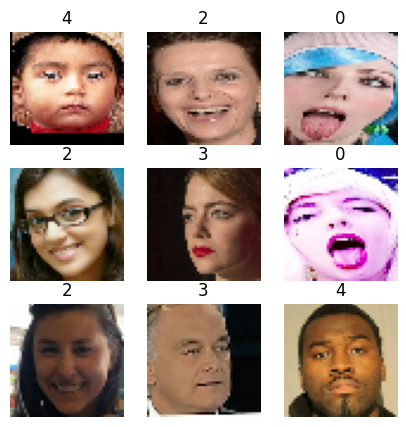

In [13]:
#visualizing the data with int lables
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

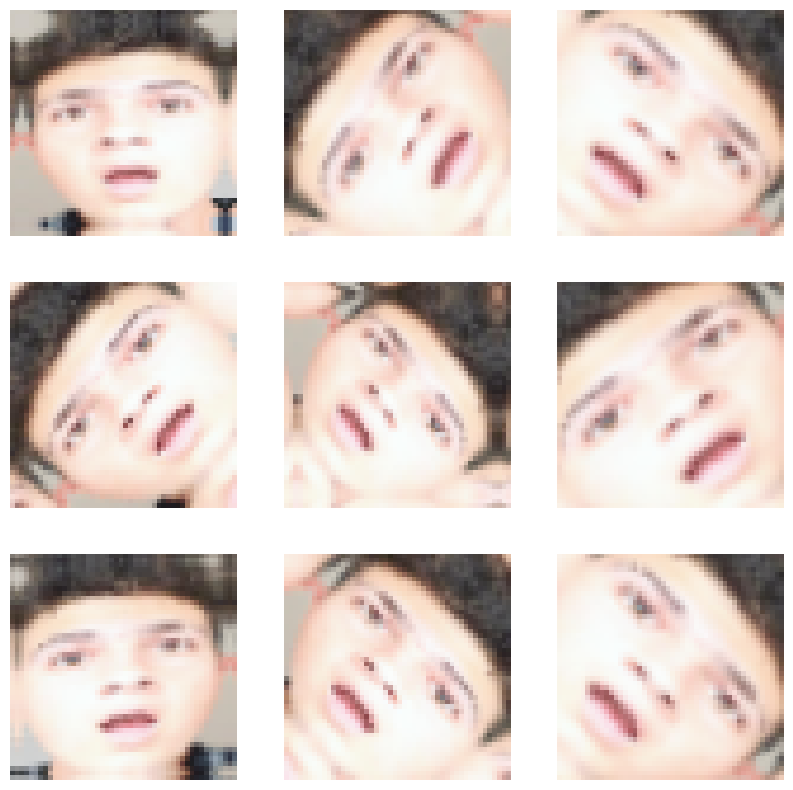

In [14]:
#Augmenting the images rotation / zomm and flip
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:

# Normalizing images
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = val_ds.map(process)




In [16]:
print(train_ds)
print(validation_ds)

<_MapDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 48, 48, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [17]:

#Building CNN Model
model=Sequential()
#input layer giving image 32 filtter , fillter size 3,3 , padding active , input shape as image size =(48,48,RGB)
#input layer giving image 32 filtter , fillter size 3,3 , padding active , input shape as image size =(48,48,RGB)

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))




In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 64)        256       
 chNormalization)                                                
                                                      

In [19]:

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [20]:

# starting the model Training time
start_time_1 = time.time()
history_model1=model.fit(train_ds,epochs=30,validation_data=validation_ds)

Epoch 1/30
310/310 [==============================] - 97s 303ms/step - loss: 1.4382 - accuracy: 0.4270 - val_loss: 1.6059 - val_accuracy: 0.3385
Epoch 2/30
310/310 [==============================] - 83s 265ms/step - loss: 1.0713 - accuracy: 0.5623 - val_loss: 1.0334 - val_accuracy: 0.5734
Epoch 3/30
310/310 [==============================] - 90s 288ms/step - loss: 0.9069 - accuracy: 0.6347 - val_loss: 1.0092 - val_accuracy: 0.6045
Epoch 4/30
310/310 [==============================] - 95s 305ms/step - loss: 0.7915 - accuracy: 0.6776 - val_loss: 0.9212 - val_accuracy: 0.6199
Epoch 5/30
310/310 [==============================] - 93s 296ms/step - loss: 0.6827 - accuracy: 0.7301 - val_loss: 0.9732 - val_accuracy: 0.6288
Epoch 6/30
310/310 [==============================] - 93s 297ms/step - loss: 0.5949 - accuracy: 0.7639 - val_loss: 0.9663 - val_accuracy: 0.6357
Epoch 7/30
310/310 [==============================] - 91s 290ms/step - loss: 0.5322 - accuracy: 0.7865 - val_loss: 0.9177 - val_ac

In [21]:
#printing Training time for the model
train_time_1 = time.time() - start_time_1
print("Train Time Model 1:", train_time_1, "seconds")

Train Time Model 1: 3625.434998989105 seconds


In [35]:
# Computing AUC score
from sklearn.metrics import roc_auc_score
import numpy as np

# Get predictions from the model
predictions = model.predict(test_ds)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Flatten true labels
true_labels = np.concatenate([labels for _, labels in test_ds], axis=0)

auc_score = roc_auc_score(true_labels, predictions, multi_class="ovr")
print("AUC Score:", auc_score)



97/97 [==============================] - 20s 188ms/step
AUC Score: 0.4978251200423604


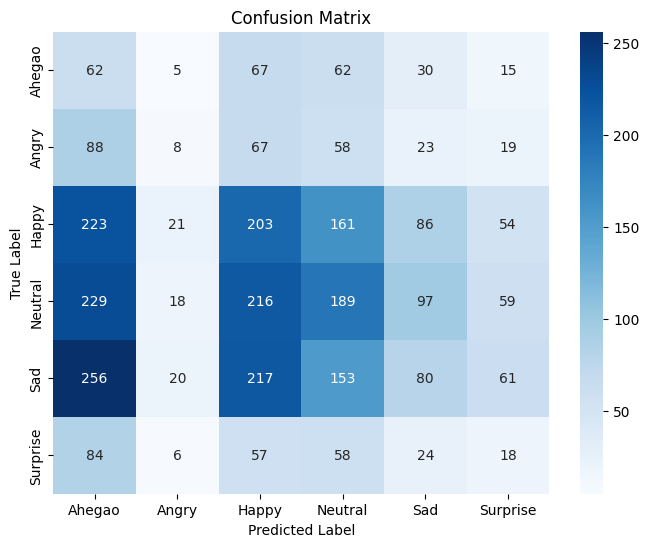

In [36]:
# Ploting confusion matrix
class_labels = ["Ahegao", "Angry", "Happy", "Neutral", "Sad", "Surprise"]

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [54]:
model.save("/content/drive/MyDrive/DL/FaceExpressions/face_exp_model1.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:

#Building first CNN  Model
model_2=Sequential()
#input layer giving image 32 filtter , fillter size 3,3 , padding active , input shape as image size =(128,128,RGB)
model_2.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(48,48,3)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_2.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_2.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_2.add(Flatten())

model_2.add(Dense(128,activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(64,activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(6, activation='softmax'))


model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        896       
                                                                 
 batch_normalization_3 (Bat  (None, 46, 46, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 21, 21, 64)        256       
 chNormalization)                                                
                                                      

In [24]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# starting the model Training time
start_time_2 = time.time()

history_model2=model_2.fit(train_ds,epochs=30,validation_data=validation_ds
)

Epoch 1/30
310/310 [==============================] - 94s 296ms/step - loss: 1.7816 - accuracy: 0.2587 - val_loss: 1.5921 - val_accuracy: 0.2972
Epoch 2/30
310/310 [==============================] - 92s 295ms/step - loss: 1.5377 - accuracy: 0.3552 - val_loss: 1.3983 - val_accuracy: 0.4189
Epoch 3/30
310/310 [==============================] - 91s 293ms/step - loss: 1.3750 - accuracy: 0.4289 - val_loss: 1.2687 - val_accuracy: 0.5172
Epoch 4/30
310/310 [==============================] - 83s 266ms/step - loss: 1.2789 - accuracy: 0.4635 - val_loss: 1.2062 - val_accuracy: 0.5273
Epoch 5/30
310/310 [==============================] - 91s 292ms/step - loss: 1.2047 - accuracy: 0.4883 - val_loss: 1.2158 - val_accuracy: 0.5115
Epoch 6/30
310/310 [==============================] - 92s 293ms/step - loss: 1.1714 - accuracy: 0.5091 - val_loss: 1.4316 - val_accuracy: 0.3959
Epoch 7/30
310/310 [==============================] - 81s 259ms/step - loss: 1.1129 - accuracy: 0.5283 - val_loss: 1.1631 - val_ac

In [25]:
#printing Training time for the model
train_time_2 = time.time() - start_time_2
print("Train Time Model 2:", train_time_2, "seconds")

Train Time Model 2: 3834.0357971191406 seconds


In [56]:
model_2.save("/content/drive/MyDrive/DL/FaceExpressions/face_exp_model2.h5")


In [37]:
# Computing AUC score
from sklearn.metrics import roc_auc_score
import numpy as np

# Get predictions from the model
predictions = model_2.predict(test_ds)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Flatten true labels
true_labels = np.concatenate([labels for _, labels in test_ds], axis=0)

auc_score = roc_auc_score(true_labels, predictions, multi_class="ovr")
print("AUC Score:", auc_score)


97/97 [==============================] - 18s 163ms/step
AUC Score: 0.49858540406839297


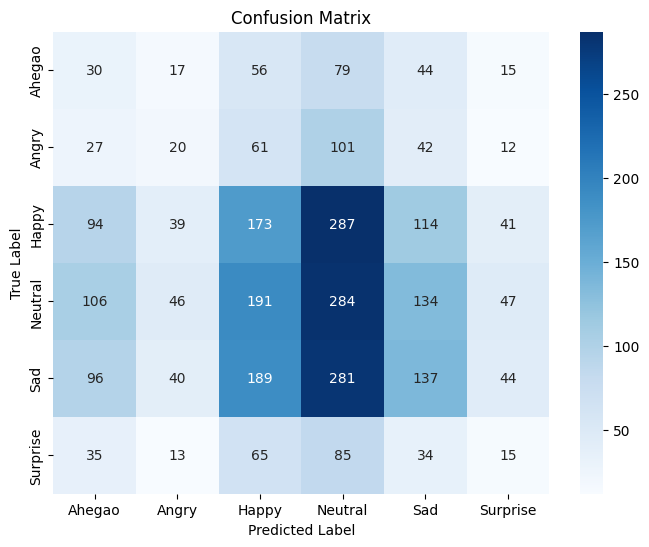

In [38]:

# Ploting confusion matrix
class_labels = ["Ahegao", "Angry", "Happy", "Neutral", "Sad", "Surprise"]

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

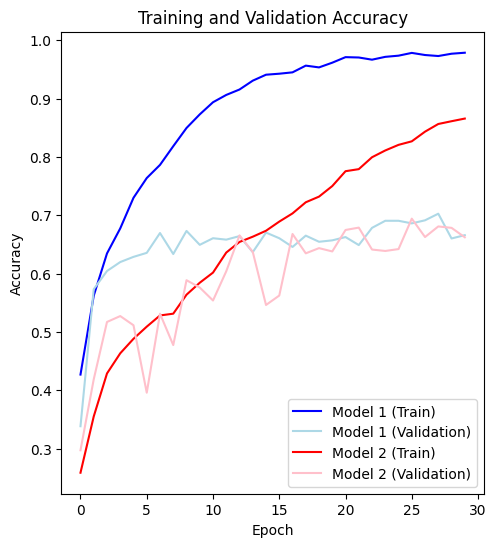

In [27]:
# Plot training and validation accuracy

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_model1.history['accuracy'], label='Model 1 (Train)', color='blue')
plt.plot(history_model1.history['val_accuracy'], label='Model 1 (Validation)', color='lightblue')
plt.plot(history_model2.history['accuracy'], label='Model 2 (Train)', color='red')
plt.plot(history_model2.history['val_accuracy'], label='Model 2 (Validation)', color='pink')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

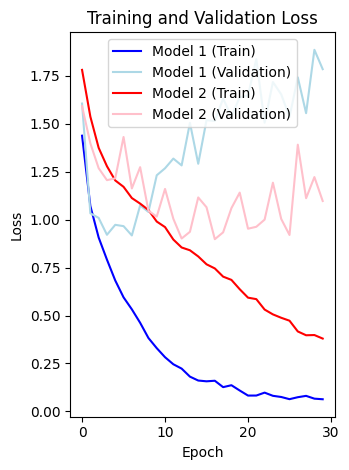

In [28]:
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_model1.history['loss'], label='Model 1 (Train)', color='blue')
plt.plot(history_model1.history['val_loss'], label='Model 1 (Validation)', color='lightblue')
plt.plot(history_model2.history['loss'], label='Model 2 (Train)', color='red')
plt.plot(history_model2.history['val_loss'], label='Model 2 (Validation)', color='pink')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Prediction**

In [57]:
model =  tf.keras.models.load_model("/content/drive/MyDrive/DL/FaceExpressions/face_exp_model1.h5")
model_2 =  tf.keras.models.load_model("/content/drive/MyDrive/DL/FaceExpressions/face_exp_model2.h5")

In [64]:


classes = [
    "Ahegao",
    "Angry",
    "Happy",
    "Neutral",
    "Sad",
    "Surprise"
]


#FIrst model Prediction function
def Pred(img):
    img = Image.open(img)
    img = img.resize((48,48))
    test = tf.reshape(tf.constant(np.array(img)/255,dtype=tf.float32), (-1,48,48,3))
    preds = model.predict(test,verbose = False)[0]*100
    # print(preds)
    preds = tf.math.round(preds)
    confidence = tf.reduce_max(preds)

    index = int(tf.where(preds == confidence)[0][0])
    pred = classes[index]
    return f"{pred.title()} {int(confidence)}%"

#second model Prediction function
def Pred_2(img):
    img = Image.open(img)
    img = img.resize((48,48))
    test = tf.reshape(tf.constant(np.array(img)/255,dtype=tf.float32), (-1,48,48,3))
    preds = model_2.predict(test,verbose = False)[0]*100
    # print(preds)
    preds = tf.math.round(preds)
    confidence = tf.reduce_max(preds)

    index = int(tf.where(preds == confidence)[0][0])
    pred = classes[index]
    return f"{pred.title()} {int(confidence)}%"

**First model Prediction**


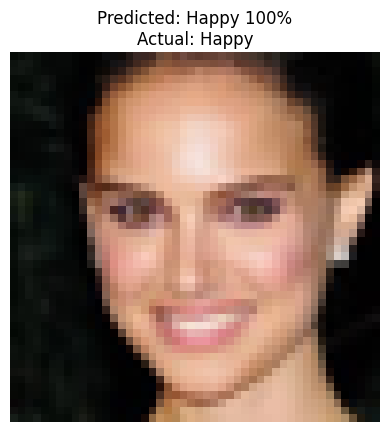

In [68]:


# Get a random image path from the test directory
test_dir = "/content/FaceExpressions_new/test"
random_class = random.choice(os.listdir(test_dir))
random_image = random.choice(os.listdir(os.path.join(test_dir, random_class)))
image_path = os.path.join(test_dir, random_class, random_image)

# Determine the actual class
actual_class = os.path.basename(os.path.dirname(image_path))

# Load and resize the image
img = Image.open(image_path)
img = img.resize((48, 48))

# Display the image and its prediction along with the actual class
plt.imshow(img)
predicted_class = Pred(image_path)
plt.title(f"Predicted: {predicted_class}\nActual: {actual_class}")
plt.axis("off")
plt.show()


1/1 [==============================] - 0s 23ms/step


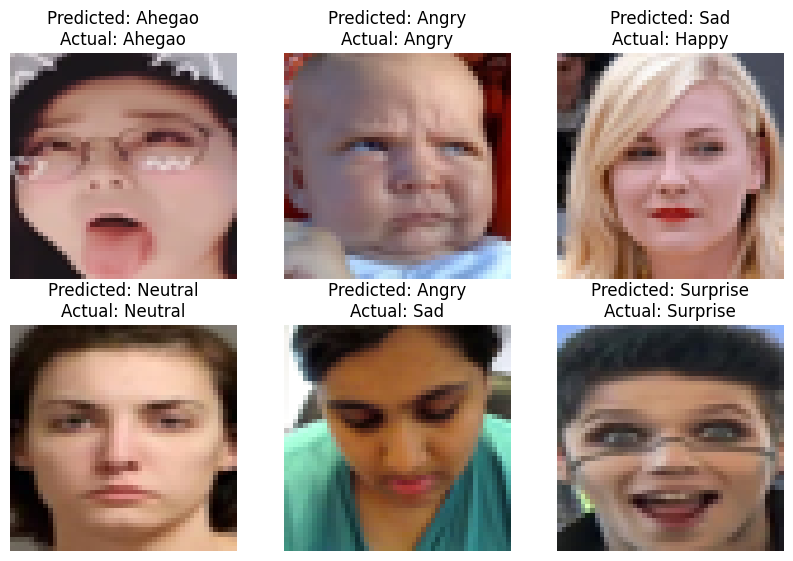

In [66]:


# Get paths to one random image from each class in the test set
class_image_paths = {
    "Ahegao": None,
    "Angry": None,
    "Happy": None,
    "Neutral": None,
    "Sad": None,
    "Surprise": None
}

test_dir = "/content/FaceExpressions_new/test"

for class_name in class_image_paths:
    class_dir = os.path.join(test_dir, class_name)
    class_images = os.listdir(class_dir)
    random_image = random.choice(class_images)
    class_image_paths[class_name] = os.path.join(class_dir, random_image)

# Plot images with predictions and actual classes for each class
plt.figure(figsize=(10, 10))
for i, (class_name, image_path) in enumerate(class_image_paths.items(), 1):
    img = Image.open(image_path)
    img = img.resize((48, 48))

    # Preprocess the image for prediction
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get the prediction
    prediction = model.predict(img_array)
    predicted_class = classes[np.argmax(prediction)]

    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nActual: {class_name}")
    plt.axis("off")
plt.show()



# **Second model Prediction**

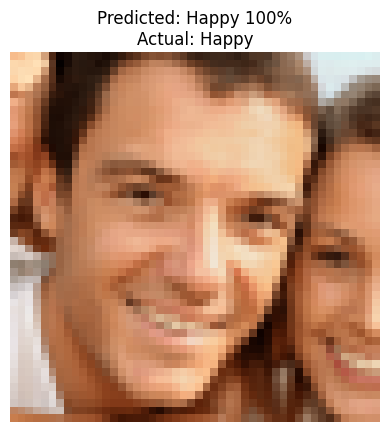

In [72]:
import os
import random

# Get a random image path from the test directory
test_dir = "/content/FaceExpressions_new/test"
random_class = random.choice(os.listdir(test_dir))
random_image = random.choice(os.listdir(os.path.join(test_dir, random_class)))
image_path = os.path.join(test_dir, random_class, random_image)

# Determine the actual class
actual_class = os.path.basename(os.path.dirname(image_path))

# Load and resize the image
img = Image.open(image_path)
img = img.resize((48, 48))

# Display the image and its prediction along with the actual class
plt.imshow(img)
predicted_class = Pred_2(image_path)
plt.title(f"Predicted: {predicted_class}\nActual: {actual_class}")
plt.axis("off")
plt.show()


1/1 [==============================] - 0s 31ms/step


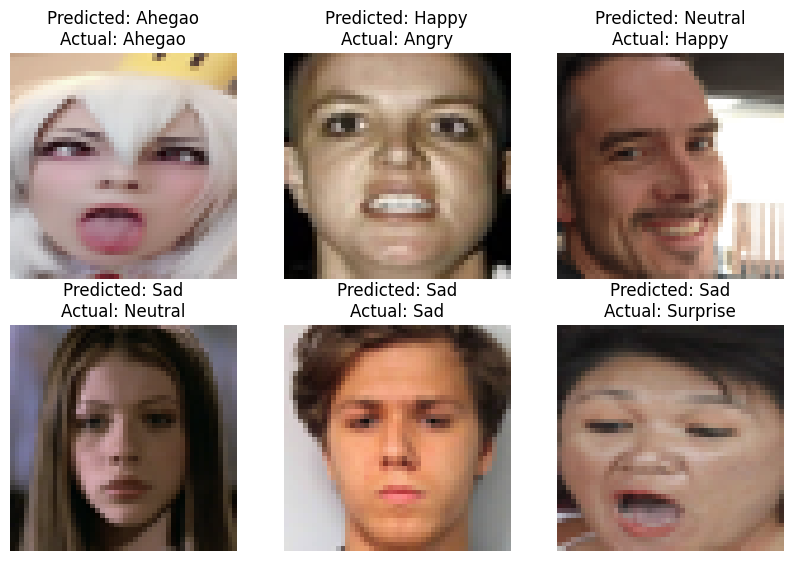

In [75]:


# taking paths to one random image from each class in the test set
class_image_paths = {
    "Ahegao": None,
    "Angry": None,
    "Happy": None,
    "Neutral": None,
    "Sad": None,
    "Surprise": None
}

test_dir = "/content/FaceExpressions_new/test"

for class_name in class_image_paths:
    class_dir = os.path.join(test_dir, class_name)
    class_images = os.listdir(class_dir)
    random_image = random.choice(class_images)
    class_image_paths[class_name] = os.path.join(class_dir, random_image)

# Plot images with predictions and actual classes for each class
plt.figure(figsize=(10, 10))
for i, (class_name, image_path) in enumerate(class_image_paths.items(), 1):
    img = Image.open(image_path)
    img = img.resize((48, 48))

    # Preprocess the image for prediction
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get the prediction
    prediction = model_2.predict(img_array)
    predicted_class = classes[np.argmax(prediction)]

    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nActual: {class_name}")
    plt.axis("off")
plt.show()


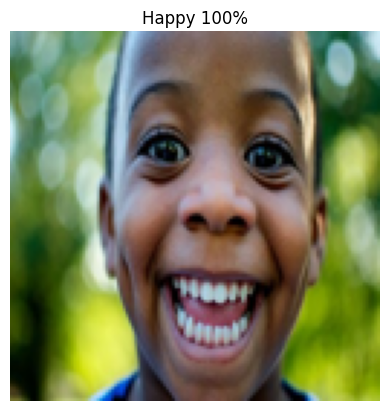

In [79]:
img = Image.open("/content/happy.jpg")
img = img.resize((128, 128))

plt.imshow(img)
plt.title(Pred("/content/happy.jpg"))
plt.axis("off")
plt.show()